# Credible Threats

## Calling data

In [3]:
# Calling Python Packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
from ipywidgets import Layout
import seaborn as sns
import math
sns.set()


filename = 'imdb.csv'

def gen_df(filename):

    # Get .csv.file
    data = pd.read_csv(filename, sep=';', encoding='latin-1', escapechar='\\')

    # Read file into pandas dataframe
    df = pd.DataFrame(data)

    # Drop unwanted columns
    for i in range(44,48):
        df.drop(columns=[f'Unnamed: {i}'], inplace=True)

    df.drop(columns=['fn','wordsInTitle','url'], inplace=True)

    # Keep only observations of movie-type
    I = df['type'] == 'video.movie'
    df = df.loc[I]
    df.drop(columns=['type'], inplace=True)

    # Drop observations with missing data
    df.dropna(inplace=True)

    # Replace 0's in imdb-ratings
    df['imdbRating'] = df['imdbRating'].astype(str)
    df['imdbRating'].replace(regex=True, inplace=True,to_replace='0',value='')
    df['imdbRating'] = df['imdbRating'].astype(float)

    # Transform duration from seconds to hours
    df['duration'] = df['duration']/60**2

    # Drop years before 1920 and 2014 because of few obervations
    I = (df['year']>=1920) & (df['year']<=2013)
    df = df.loc[I]

    # Change the type of 'year' to integer
    df['year'] = df['year'].astype(int)    
    
    # Sort observations and reset index
    df.sort_values('year', inplace=True)
    df.reset_index(inplace=True)


    # Generating variable that shows the decade (as a string)
    year_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    df['decade'] = ''
    for i,start in enumerate(year_list):
        end = start+10
        df.loc[(df['year'] >= start) & (df['year'] < end), 'decade'] = f'{year_list[i]}s'

    return df

df = gen_df(filename)


## Descriptive Data

In [3]:
# Summary Statistics by Decade  
decade = ["all", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]

def summ_stat(decade):
    pd.options.display.float_format = "{:.2f}".format
    if decade == "all": 
        return df[["year", "imdbRating", "duration", "nrOfWins", "nrOfNominations"]].describe() 
    else: 
        df_decade = df.loc[df["decade"] == decade]
        return df_decade[["year", "imdbRating", "duration", "nrOfWins", "nrOfNominations"]].describe() 
    
# summ_stat(time="1920s")
    
# df[["year", "imdbRating", "duration", "nrOfWins", "nrOfNominations"]].describe() 
# df.groupby("decade").describe() 

def summ_stat_interactive(): 
    widgets.interact(summ_stat, 
    
    # Decade Dropdown 
    decade = widgets.Dropdown(
    decription="Decade", 
    options=decade, 
    value="all"));

summ_stat_interactive()

interactive(children=(Dropdown(description='decade', options=('all', '1920s', '1930s', '1940s', '1950s', '1960…

In [6]:
# Defining function that rounds up to next hundred 
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

def fig3_J():    
    
    imdb = df.copy()
    time_var = ('year', 'decade')
    decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
    
    def fig(time_var):    
        # Generate variable that counts number of observation/movies in each year
        imdb['temp']=1
        imdb['tot_film'] = imdb.groupby(time_var)['temp'].transform(lambda x : x.sum())
        del imdb['temp']

        # Make new dataframe that only take one value per year. 
        # The dataframe only contain the year indicator and number of movies in the given year
        y = pd.DataFrame(imdb.groupby(time_var)['tot_film'].first())
        y.reset_index(inplace=True)

        # Setting max value of y-axis to next hundred of max number of movies
        temp = imdb['tot_film'].max()
        y_max = roundup(temp)

        # Plotting the number of movies per year
        fig = plt.figure(figsize=(7,6))
        ax1 = fig.add_subplot(1,1,1)

        if time_var == 'year':
            ax1.bar(y[time_var], y['tot_film'], color='black', width=0.55)
        else:
            ax1.bar(y[time_var], y['tot_film'], color='black')

        ax1.set_ylabel('Numbers of movies')
        ax1.set_title(f'Numbers of movies, 1920-2013')
        ax1.set_ylim([0,y_max])

        if time_var == 'year':            
            ax1.set_xticks(decades)
            every_nth = 1
            for n, label in enumerate(ax1.xaxis.get_ticklabels()):
                if n % every_nth != 0:
                    label.set_visible(False)

    widgets.interact(fig,
        time_var = widgets.Dropdown(description='Time unit', value='year', options=time_var, 
                    layout=Layout(width='175px')),
    );    

fig3_J()

interactive(children=(Dropdown(description='Time unit', layout=Layout(width='175px'), options=('year', 'decade…

## Staring in the Eyes of Genres

### Number of Movies in Each Genre

In [5]:
# Generating genre list
genre_list = list(df)[13:41]

# Counting movies in each genre
for i in genre: 
    sum = df[i].sum(axis=0)
    print(f'Number of {i} movies: {sum:.0f}')

Number of Action movies: 1772
Number of Adult movies: 16
Number of Adventure movies: 1456
Number of Animation movies: 534
Number of Biography movies: 541
Number of Comedy movies: 3327
Number of Crime movies: 1638
Number of Documentary movies: 778
Number of Drama movies: 5109
Number of Family movies: 685
Number of Fantasy movies: 679
Number of FilmNoir movies: 190
Number of GameShow movies: 2
Number of History movies: 460
Number of Horror movies: 935
Number of Music movies: 269
Number of Musical movies: 332
Number of Mystery movies: 750
Number of News movies: 2
Number of RealityTV movies: 2
Number of Romance movies: 1707
Number of SciFi movies: 731
Number of Short movies: 380
Number of Sport movies: 205
Number of TalkShow movies: 3
Number of Thriller movies: 1235
Number of War movies: 442
Number of Western movies: 292


### Share of movies pr. genre

In [8]:
# Generate genre list
genre_list = list(df)[13:41]

def genre_share_fig():

    def _plot_1(df,genre,timevar):

        df['count'] = 1
        df['movies_year'] = df.groupby(timevar)['count'].transform(lambda x: x.sum())  

        # Plot year sum of different genres
        for i in genre:
    
            # Calculate sum of movies by timevariable, and share of movies within time that is of a certain genre
            df[f'{i}_time'] = df.groupby(timevar)[i].transform(lambda x: x.sum())
            df[f'{i} share'] = df[f'{i}_time']/df['movies_year']

            # Take first element of each timevariable group
            y_share = df.groupby(timevar)[f'{i} share'].first()

            # Plot the first eleents
            y_share.plot(kind='line', sharex='col', sharey='row')


            # Add labels and title
            plt.xlabel(timevar)
            plt.ylabel('share of movies')
            if len(genre) == 1:
                plt.title(i)
            if len(genre) > 1:
                plt.legend(loc='upper left')

        #plt.show()

    def plot_1(df):

        widgets.interact(_plot_1,
                        df = widgets.fixed(df),
                        genre = widgets.SelectMultiple(
                            options = genre_list,
                            description = 'Genres',
                            disabled = False),
                        timevar = widgets.Dropdown(
                        options = ['year', 'decade'],
                        description = 'Timevariable',
                        disabled = False))

    plot_1(df)

genre_share_fig()



interactive(children=(SelectMultiple(description='Genres', options=('Action', 'Adult', 'Adventure', 'Animation…

### Correlation Between Genres

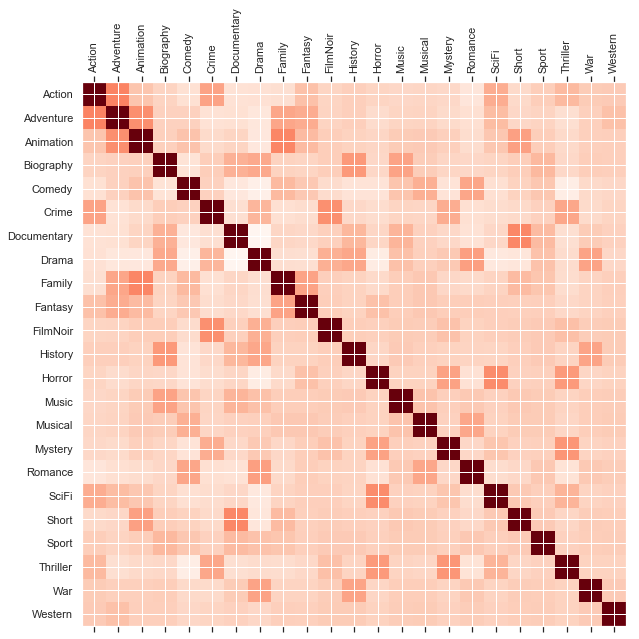

In [14]:
# New Genre List (Dropping Genres with less than 100 movies)
genre_new = ['Action', 'Adventure', 'Animation', 'Biography',
         'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
         'FilmNoir', 'History', 'Horror', 'Music', 'Musical',
         'Mystery', 'Romance', 'SciFi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


# Heat map between genres
corr = df[genre_new].corr()
# print(corr)

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr, cmap=plt.cm.Reds)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns);

## Rated PG 13 - Parents Strongly Cautioned

### Histogram of Number of Movies pr. Rating

In [8]:
# Interactive Histogram
def histogram(variable, genre, bins_num):
        df_hist = df.loc[df[genre] == 1]
        plt.hist(df_hist[variable], bins=bins_num)
    
        # Labels
        plt.title("Number of Movies pr. Rating")
        plt.xlabel("Rating")
        plt.xticks(range(1,11))
    
# histogram("imdbRating", "Comedy")   # Remember quote marks around variable names. 


def hist_interactive(variable): 
    widgets.interact(histogram, 
    variable = widgets.fixed(variable), 
    
    # Genre Dropdown
    genre = widgets.Dropdown(
    description="Genre", 
    options=genre, 
    value="Comedy"),
    
    # Bins slider 
    bins_num=widgets.IntSlider(
    value=10,
    description="Bins", 
    min=1,
    max=50, 
    step=1,
    disabled=False,
    continuous_update=False)
    ); 

hist_interactive("imdbRating")

NameError: name 'genre' is not defined

### Ratings over time

In [11]:
def fig3_J():
    
    imdb = df.copy()
    time_var = ['year', 'decade']
    decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
    
    def fig(time_var):    
        
        # Creating variable that takes the average IMDB rating per year
        imdb['avg_rat'] = imdb.groupby(time_var)['imdbRating'].transform(lambda x : x.mean())
        imdb['avg_rat_index'] = imdb['avg_rat'].transform(lambda x : x/x[0]*100)
        
        # Make new dataframe that only take one value per year. 
        # The dataframe only contain the year indicator and number of movies in the given year
        y = pd.DataFrame(imdb.groupby(time_var)['avg_rat'].first())
        y.reset_index(inplace=True)
        x = pd.DataFrame(imdb.groupby(time_var)['avg_rat_index'].first())
        x.reset_index(inplace=True)

        #y['avg_rat_index'] = y['avg_rat']/y['avg_rat'][0]*100

        fig = plt.figure(figsize=(13,6))
        
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(y[time_var], y['avg_rat'], color='black')
        ax1.set_ylabel('Average rating')
        ax1.set_title(f'Average IMDB rating, 1920-2013')
        ax1.set_ylim([0,10])

        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(x[time_var], x['avg_rat_index'], color='black')
        ax2.set_ylabel(f'Index: 1920=100')
        ax2.set_title(f'Normalized average of IMDB rating, 1920-2013')
        ax2.set_ylim([80,105])
        
        if time_var == 'year':            
            ax1.set_xticks(decades)
            every_nth = 1
            for n, label in enumerate(ax1.xaxis.get_ticklabels()):
                if n % every_nth != 0:
                    label.set_visible(False)
            
            ax2.set_xticks(decades)
            every_nth = 1
            for n, label in enumerate(ax2.xaxis.get_ticklabels()):
                if n % every_nth != 0:
                    label.set_visible(False)
                    
    widgets.interact(fig,
        time_var = widgets.Dropdown(description='Time unit', value='year', options=time_var, 
                    layout=Layout(width='175px')),
    );    

fig3_J()

interactive(children=(Dropdown(description='Time unit', layout=Layout(width='175px'), options=('year', 'decade…

### Does good movies have better ratings?

In [15]:
def fig1_J():
    imdb = df.copy()
    
    # Creating variable that groups number of wins
    imdb['nrw'] = 0
    imdb.loc[(imdb['nrOfWins'] > 0) & (imdb['nrOfWins'] < 10), ['nrw']] = 1
    imdb.loc[(imdb['nrOfWins'] >= 10) & (imdb['nrOfWins'] < 20), ['nrw']] = 2
    imdb.loc[(imdb['nrOfWins'] >= 20) & (imdb['nrOfWins'] < 30), ['nrw']] = 3
    imdb.loc[(imdb['nrOfWins'] >= 30) & (imdb['nrOfWins'] < 40), ['nrw']] = 4
    imdb.loc[(imdb['nrOfWins'] >= 40), ['nrw']] = 5
    nrwins = ['0', '0-10', '10-20', '20-30', '30-40', '40+']

    # Defining function to plot figure
    def fig(df, index_0, index_1, index_2, index_3, index_4, index_5):
        
        # Make lists and a temporaty dataframe to make the plot
        temp = df.copy()
        index = [index_0, index_1, index_2, index_3, index_4, index_5]
        color = ['orange', 'blue', 'green', 'red', 'turquoise', 'black']
        
        # Loop over kategory to plot their rating distribution and plot the distribution
        for i,val in enumerate(nrwins):
            nrwins_i = temp.loc[(temp['nrw'] == i)]
            if index[i] == True:  # Only plot distribution if box is 'checked'
                sns.distplot(nrwins_i['imdbRating'], hist = False, kde = True,
                         kde_kws = {'linewidth': 2}, label = val, color=color[i]
                     )
        plt.legend(loc='upper left')
        plt.title('IMDB rating conditioned on numbers of award wins')
        plt.xlabel('IMDB rating')
        plt.ylabel('Density')
    
    # Interactive part: Making checkbox win-categories
    widgets.interact(fig,
        df=widgets.fixed(imdb),
        index_0=widgets.Checkbox(description=nrwins[0], value=True, disabled=False),
        index_1=widgets.Checkbox(description=nrwins[1], value=True, disabled=False),
        index_2=widgets.Checkbox(description=nrwins[2], value=True, disabled=False),
        index_3=widgets.Checkbox(description=nrwins[3], value=True, disabled=False),
        index_4=widgets.Checkbox(description=nrwins[4], value=True, disabled=False),
        index_5=widgets.Checkbox(description=nrwins[5], value=True, disabled=False),
    );

fig1_J()

interactive(children=(Checkbox(value=True, description='0'), Checkbox(value=True, description='0-10'), Checkbo…

### Does we have a selection problem?

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import seaborn as sns
import math
from data_gen import gen_df

def fig4_J():
    ## Importing data and making new dataframe
    filename = 'imdb.csv'
    df = gen_df(filename)
    imdb = df.copy()
    
    ## Making variable that shows total numbers of award win per decade
    imdb['nrOfWins_tot'] = imdb.groupby('decade')['nrOfWins'].transform(lambda x : x.sum())
    
    ## Generating variable that take a movies share of total win in the decade
    imdb['nrOfWins_share'] = imdb['nrOfWins']/imdb['nrOfWins_tot']*100
    
    ## Taking the mean/median/P75 on the win share in each decade
    imdb['nrOfWins_share_avg'] = imdb.groupby('decade')['nrOfWins_share'].transform(lambda x: x.mean())
    imdb['nrOfWins_share_med'] = imdb.groupby('decade')['nrOfWins_share'].transform(lambda x: x.median())
    imdb['nrOfWins_share_p75'] = imdb.groupby('decade')['nrOfWins_share'].transform(lambda x: np.percentile(x,95))


    ## Generate variable that counts number of observation/movies in each year
    imdb['temp']=1
    imdb['tot_film'] = imdb.groupby('decade')['temp'].transform(lambda x : x.sum())
    del imdb['temp']

    ## Creating a new dataframe that have one observation per decade
    y = pd.DataFrame(imdb.groupby('decade')['nrOfWins_tot'].first())
    y['nrOfWins_share_avg'] = imdb.groupby('decade')['nrOfWins_share_avg'].first()
    y['nrOfWins_share_med'] = imdb.groupby('decade')['nrOfWins_share_med'].first()
    y['nrOfWins_share_p75'] = imdb.groupby('decade')['nrOfWins_share_p75'].first()
    y['tot_film'] = imdb.groupby('decade')['tot_film'].first()
    y.reset_index(inplace=True)

    ## Plotting the total numbers of wins and movies and the average share of wins per decade
    def fig(temp1, temp2):
        fig = plt.figure(figsize=(14,6))

        # Figure 1
        ax1 = fig.add_subplot(1,2,1)
        ax1.plot(y['decade'], y['nrOfWins_share_avg'], color='blue', label='Average share of wins')
        if temp1 == True:
            ax1.plot(y['decade'], y['nrOfWins_share_med'], color='blue', label='Median share of wins', linestyle='dashed')
        ax1.set_ylim([0,0.7])
        if temp2 == True:
            ax1.plot(y['decade'], y['nrOfWins_share_p75'], color='blue', label='P75 share of wins', linestyle='dotted')
            ax1.set_ylim([0,4])
        ax1.legend(loc='upper right');
        ax1.set_ylabel('Share of total award wins in the decade, pct.')
        ax1.set_title(f'Average numbers of award wins normalized by total award wins')        
        
        # Figure 2
        ax2 = fig.add_subplot(1,2,2)
        ax2.plot(y['decade'], y['tot_film'], color='blue', label='Number of movies')
        ax2.plot(y['decade'], y['nrOfWins_tot'], color='black', label='Numbers of award wins')
        ax2.legend(loc='upper left');
        ax2.set_ylabel('Numbers of movies/award wins')
        ax2.set_title(f'Numbers of movies and award wins by decade, 1920-2013')

    
        # Interactive part: Making checkbox stat-types
    widgets.interact(fig,
        temp1=widgets.Checkbox(description='Median', value=True, disabled=False),
        temp2=widgets.Checkbox(description='P75', value=True, disabled=False),
    );
fig4_J()

interactive(children=(Checkbox(value=True, description='Median'), Checkbox(value=True, description='P75'), Out…

### Swarm Plot of Ratings pr. Decade

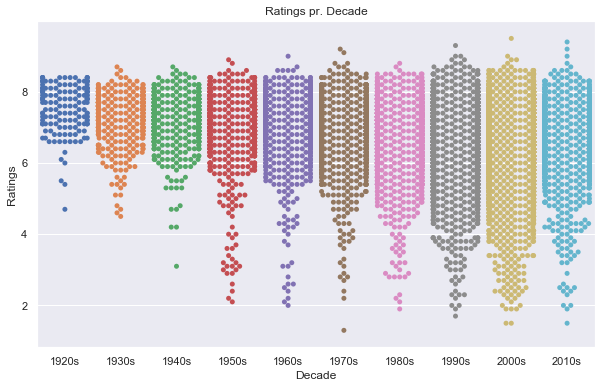

In [18]:
# Swarm plot (Consider comparing decades)
def swarm_plot(y="imdbRating"): 
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,1,1)
    ax1 = sns.swarmplot(x = "decade", y = y, data=df)
    if y == "imdbRating": 
        ax1.set_title("Ratings pr. Decade")
        ax1.set_ylabel("Ratings")
    elif y == "nrOfWins": 
        ax1.set_title("Wins pr. Decade")
        ax1.set_ylabel("Nr. of Wins")
    elif y == "nrOfNominations": 
        ax1.set_title("Nominations pr. Decade")
        ax1.set_ylabel("Nr. of Nominations")
    elif y == "duration": 
        ax1.set_title("Duration pr. Decade")
        ax1.set_ylabel("Duration")
    else: 
        ax1.set_title(f"{y} pr. Decade")
        ax1.set_ylabel(y)
    ax1.set_xlabel("Decade")
    

swarm_plot()

### Correlation between Ratings and News Articles

In [ ]:
# Insert < "Sebberfranskcognacs kode" >